In [1]:
import warnings
import torch
import pandas as pd
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased")

In [3]:
import json

with open("modified_message_contents.json") as f:
    ners = json.load(f)

with open("all_prompts.json") as f:
    prod = json.load(f)

In [4]:
# iterate over all prompts
data = {}
data['tokens'] = []
data['ner_tags'] = []

for _, prod_list in prod.items():
    for product in prod_list:
        data['tokens'].append(prod_list[product])

for _, ner_list in ners.items():
    for ner in ner_list:
        data['ner_tags'].append(ner_list[ner])

In [5]:
for i in range(len(data['tokens']) - 1, -1, -1):
    if len(data['tokens'][i]) != len(data['ner_tags'][i]):
        del data['tokens'][i]
        del data['ner_tags'][i]

In [6]:
len(data['tokens']), len(data['ner_tags'])

(14840, 14840)

In [7]:
# iterate over every list of ner_tags, rename some of the tags
rename_list = {
    'B-size': 'B-UoM', 
    'I-size': 'I-UoM',
    'B-intellectual_properties': 'B-content',
    'I-intellectual_properties': 'I-content'
}

for i in range(len(data['ner_tags'])):
    for j in range(len(data['ner_tags'][i])):
        if data['ner_tags'][i][j] in rename_list:
            data['ner_tags'][i][j] = rename_list[data['ner_tags'][i][j]]

In [8]:
model.config.label2id.keys()

dict_keys(['B-UoM', 'B-color', 'B-condition', 'B-content', 'B-core_product_type', 'B-creator', 'B-department', 'B-material', 'B-modifier', 'B-occasion', 'B-origin', 'B-price', 'B-product_name', 'B-product_number', 'B-quantity', 'B-shape', 'B-time', 'I-UoM', 'I-color', 'I-condition', 'I-content', 'I-core_product_type', 'I-creator', 'I-department', 'I-material', 'I-modifier', 'I-occasion', 'I-origin', 'I-price', 'I-product_name', 'I-product_number', 'I-quantity', 'I-shape', 'I-time', 'O'])

In [9]:
real_tags = list(model.config.label2id.keys())

# Collect indices to delete
indices_to_delete = []

for i in range(len(data['ner_tags']) - 1, -1, -1):
    for j in range(len(data['ner_tags'][i])):
        if data['ner_tags'][i][j] not in real_tags:
            print(i, data['tokens'][i], data['ner_tags'][i])
            indices_to_delete.append(i)
            break  # No need to check further if one tag is found

indices_to_delete, len(indices_to_delete)

14836 ['SUUKSESS', 'Women', 'Sexy', 'Tummy', 'Control', 'One', 'Piece', 'Swimsuits', 'Halter', 'Push', 'Up', 'Bathing', 'Suits'] ['B-creator', 'B-department', 'B-modifier', 'B-feature', 'I-feature', 'B-quantity', 'I-quantity', 'B-core_product_type', 'I-core_product_type', 'B-shape', 'B-modifier', 'B-core_product_type', 'I-core_product_type']
14826 ['Stelle', 'Women', 'Ballet', 'Shoes', 'Highly', 'Stretch', 'Canvas', 'Adult', 'Ballet', 'Slippers', 'Split', 'Sole'] ['B-creator', 'B-department', 'B-product_type', 'I-product_type', 'B-modifier', 'B-modifier', 'B-material', 'B-department', 'I-product_type', 'I-product_type', 'B-modifier', 'B-sole_type']
14825 ['Egoelife', 'LB', 'BBPHF18', 'Unisex', 'Casual', 'Canvas', 'Satchel', 'Messenger', 'Bag', 'for', 'Traveling'] ['B-creator', 'B-product_number', 'I-product_number', 'B-department', 'B-intended_use', 'B-material', 'B-core_product_type', 'I-core_product_type', 'B-core_product_type', 'O', 'B-intended_use']
14824 ['Fashio', 'FF', 'Mens', '

([14836,
  14826,
  14825,
  14824,
  14823,
  14822,
  14821,
  14820,
  14804,
  14787,
  14780,
  14778,
  14767,
  14766,
  14765,
  14762,
  14758,
  14756,
  14739,
  14735,
  14697,
  14696,
  14695,
  14694,
  14693,
  14692,
  14670,
  14598,
  14592,
  14573,
  14451,
  14428,
  14339,
  14334,
  14331,
  14322,
  14321,
  14319,
  14318,
  14316,
  14315,
  14239,
  14227,
  14222,
  14219,
  14216,
  14212,
  14211,
  14210,
  14209,
  14208,
  14207,
  14206,
  14205,
  14204,
  14160,
  14156,
  14072,
  14070,
  14068,
  14065,
  14064,
  14063,
  14062,
  14060,
  14059,
  14058,
  14055,
  14050,
  13991,
  13972,
  13964,
  13963,
  13962,
  13958,
  13947,
  13912,
  13909,
  13908,
  13889,
  13874,
  13872,
  13870,
  13868,
  13836,
  13653,
  13647,
  13627,
  13582,
  13476,
  13466,
  13458,
  13457,
  13452,
  13417,
  13416,
  13415,
  13414,
  13413,
  13411,
  13410,
  13408,
  13407,
  13278,
  13277,
  13168,
  13164,
  13122,
  13109,
  13108,
  13107,
 

In [10]:
# Delete collected indices
for i in sorted(indices_to_delete, reverse=True):
    del data['tokens'][i]
    del data['ner_tags'][i]

In [11]:
len(data['tokens']), len(data['ner_tags'])

(13592, 13592)

In [12]:
from datasets import Dataset

dataset = Dataset.from_dict(data)

print(dataset)

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 13592
})


In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
            else:
                label_ids.append(label_to_id[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

label_to_id = model.config.label2id
id_to_label = model.config.id2label

label_all_tokens = True

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/13592 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 13592
})

In [86]:
train_dataloader

In [15]:
from torch.utils.data import DataLoader

train_size = 0.8
train_dataset = tokenized_dataset.train_test_split(train_size=train_size)["train"]
eval_dataset = tokenized_dataset.train_test_split(train_size=train_size)["test"]

print("Jumlah Training Data:", len(train_dataset))
print("Jumlah Testing Data:", len(eval_dataset))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)


Jumlah Training Data: 10873
Jumlah Testing Data: 2719


In [16]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=8)

In [17]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id_to_label[pred] for (pred, label) in zip(prediction, label) if label != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = precision_recall_fscore_support(
        [item for sublist in true_labels for item in sublist],
        [item for sublist in true_predictions for item in sublist],
        average='weighted'
    )
    
    precision, recall, f1, _ = results
    accuracy = accuracy_score(
        [item for sublist in true_labels for item in sublist],
        [item for sublist in true_predictions for item in sublist]
    )
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [32]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./results-2",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=20,
#     weight_decay=0.01
# )

# Define training arguments with aligned logging and evaluation steps
training_args = TrainingArguments(
    output_dir="./results-3",
    evaluation_strategy="steps",  # Change to "steps" for more frequent evaluation
    eval_steps=500,  # Adjust based on your dataset size and desired frequency
    logging_steps=500,  # Align logging with evaluation steps
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=25,
    weight_decay=0.01,
)

In [33]:
from transformers import AutoModelForTokenClassification, Trainer

model = AutoModelForTokenClassification.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased", num_labels=len(label_to_id))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [34]:
trainer.train()

  0%|          | 0/17000 [00:00<?, ?it/s]

{'loss': 1.5153, 'learning_rate': 1.9411764705882355e-05, 'epoch': 0.74}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 1.0736773014068604, 'eval_precision': 0.6839741640138551, 'eval_recall': 0.6884849122622398, 'eval_f1': 0.677912413665395, 'eval_accuracy': 0.6884849122622398, 'eval_runtime': 2.3567, 'eval_samples_per_second': 1153.754, 'eval_steps_per_second': 72.136, 'epoch': 0.74}
{'loss': 1.1154, 'learning_rate': 1.8823529411764708e-05, 'epoch': 1.47}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.9492722749710083, 'eval_precision': 0.7208159321682098, 'eval_recall': 0.7183973060429876, 'eval_f1': 0.7153663271977756, 'eval_accuracy': 0.7183973060429876, 'eval_runtime': 2.4112, 'eval_samples_per_second': 1127.656, 'eval_steps_per_second': 70.504, 'epoch': 1.47}
{'loss': 1.0108, 'learning_rate': 1.823529411764706e-05, 'epoch': 2.21}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.8643820881843567, 'eval_precision': 0.7437254901072122, 'eval_recall': 0.7429691405119571, 'eval_f1': 0.7395717188226706, 'eval_accuracy': 0.7429691405119571, 'eval_runtime': 2.3812, 'eval_samples_per_second': 1141.86, 'eval_steps_per_second': 71.393, 'epoch': 2.21}
{'loss': 0.9392, 'learning_rate': 1.7647058823529414e-05, 'epoch': 2.94}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.8027437925338745, 'eval_precision': 0.7606905404120853, 'eval_recall': 0.759701139143932, 'eval_f1': 0.7559566773515798, 'eval_accuracy': 0.759701139143932, 'eval_runtime': 2.3885, 'eval_samples_per_second': 1138.37, 'eval_steps_per_second': 71.174, 'epoch': 2.94}
{'loss': 0.847, 'learning_rate': 1.7058823529411767e-05, 'epoch': 3.68}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.7621015310287476, 'eval_precision': 0.7727136518640835, 'eval_recall': 0.7689879245481571, 'eval_f1': 0.7661649610355905, 'eval_accuracy': 0.7689879245481571, 'eval_runtime': 2.3832, 'eval_samples_per_second': 1140.924, 'eval_steps_per_second': 71.334, 'epoch': 3.68}
{'loss': 0.7863, 'learning_rate': 1.647058823529412e-05, 'epoch': 4.41}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.701364278793335, 'eval_precision': 0.7928919212156417, 'eval_recall': 0.7903238536213202, 'eval_f1': 0.7880605896841246, 'eval_accuracy': 0.7903238536213202, 'eval_runtime': 2.3945, 'eval_samples_per_second': 1135.537, 'eval_steps_per_second': 70.997, 'epoch': 4.41}
{'loss': 0.7488, 'learning_rate': 1.5882352941176473e-05, 'epoch': 5.15}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.6692050099372864, 'eval_precision': 0.8029469612127013, 'eval_recall': 0.8003472678961353, 'eval_f1': 0.8000671707821512, 'eval_accuracy': 0.8003472678961353, 'eval_runtime': 2.3988, 'eval_samples_per_second': 1133.48, 'eval_steps_per_second': 70.869, 'epoch': 5.15}
{'loss': 0.6846, 'learning_rate': 1.5294117647058822e-05, 'epoch': 5.88}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.6260556578636169, 'eval_precision': 0.8177171217361027, 'eval_recall': 0.8143432164373471, 'eval_f1': 0.8128745096477752, 'eval_accuracy': 0.8143432164373471, 'eval_runtime': 2.4752, 'eval_samples_per_second': 1098.484, 'eval_steps_per_second': 68.68, 'epoch': 5.88}
{'loss': 0.6343, 'learning_rate': 1.4705882352941179e-05, 'epoch': 6.62}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.5826087594032288, 'eval_precision': 0.8309872755105464, 'eval_recall': 0.8305490515903291, 'eval_f1': 0.828813685943282, 'eval_accuracy': 0.8305490515903291, 'eval_runtime': 2.3739, 'eval_samples_per_second': 1145.357, 'eval_steps_per_second': 71.611, 'epoch': 6.62}
{'loss': 0.5928, 'learning_rate': 1.4117647058823532e-05, 'epoch': 7.35}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.5650515556335449, 'eval_precision': 0.83927785858936, 'eval_recall': 0.8363894662071506, 'eval_f1': 0.8361136735997398, 'eval_accuracy': 0.8363894662071506, 'eval_runtime': 2.3761, 'eval_samples_per_second': 1144.334, 'eval_steps_per_second': 71.547, 'epoch': 7.35}
{'loss': 0.5639, 'learning_rate': 1.3529411764705885e-05, 'epoch': 8.09}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.5379695296287537, 'eval_precision': 0.848715043781995, 'eval_recall': 0.8469653521349083, 'eval_f1': 0.8467843700113032, 'eval_accuracy': 0.8469653521349083, 'eval_runtime': 2.4132, 'eval_samples_per_second': 1126.738, 'eval_steps_per_second': 70.447, 'epoch': 8.09}
{'loss': 0.5139, 'learning_rate': 1.2941176470588238e-05, 'epoch': 8.82}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.507918119430542, 'eval_precision': 0.8581177805531789, 'eval_recall': 0.8574360053668675, 'eval_f1': 0.8570732925575485, 'eval_accuracy': 0.8574360053668675, 'eval_runtime': 2.3877, 'eval_samples_per_second': 1138.735, 'eval_steps_per_second': 71.197, 'epoch': 8.82}
{'loss': 0.4785, 'learning_rate': 1.235294117647059e-05, 'epoch': 9.56}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.49959808588027954, 'eval_precision': 0.8643823205176814, 'eval_recall': 0.8628291810265449, 'eval_f1': 0.8628615049380248, 'eval_accuracy': 0.8628291810265449, 'eval_runtime': 2.3695, 'eval_samples_per_second': 1147.522, 'eval_steps_per_second': 71.747, 'epoch': 9.56}
{'loss': 0.4643, 'learning_rate': 1.1764705882352942e-05, 'epoch': 10.29}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.48740896582603455, 'eval_precision': 0.8697874030224438, 'eval_recall': 0.8677225013811791, 'eval_f1': 0.8673207943770351, 'eval_accuracy': 0.8677225013811791, 'eval_runtime': 2.4113, 'eval_samples_per_second': 1127.623, 'eval_steps_per_second': 70.502, 'epoch': 10.29}
{'loss': 0.4318, 'learning_rate': 1.1176470588235295e-05, 'epoch': 11.03}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4653133451938629, 'eval_precision': 0.8763203262986788, 'eval_recall': 0.8744837020862382, 'eval_f1': 0.8747591310957293, 'eval_accuracy': 0.8744837020862382, 'eval_runtime': 2.4957, 'eval_samples_per_second': 1089.46, 'eval_steps_per_second': 68.116, 'epoch': 11.03}
{'loss': 0.3975, 'learning_rate': 1.0588235294117648e-05, 'epoch': 11.76}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4590771198272705, 'eval_precision': 0.8803620663647235, 'eval_recall': 0.8791402488753256, 'eval_f1': 0.8792295421674472, 'eval_accuracy': 0.8791402488753256, 'eval_runtime': 2.3697, 'eval_samples_per_second': 1147.409, 'eval_steps_per_second': 71.739, 'epoch': 11.76}
{'loss': 0.3702, 'learning_rate': 1e-05, 'epoch': 12.5}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4524926543235779, 'eval_precision': 0.885300522315022, 'eval_recall': 0.8839020283602115, 'eval_f1': 0.8841146655593057, 'eval_accuracy': 0.8839020283602115, 'eval_runtime': 2.3333, 'eval_samples_per_second': 1165.327, 'eval_steps_per_second': 72.86, 'epoch': 12.5}
{'loss': 0.3615, 'learning_rate': 9.411764705882354e-06, 'epoch': 13.24}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.44392773509025574, 'eval_precision': 0.8885913394045304, 'eval_recall': 0.8877956381047591, 'eval_f1': 0.8877442569729767, 'eval_accuracy': 0.8877956381047591, 'eval_runtime': 2.3312, 'eval_samples_per_second': 1166.338, 'eval_steps_per_second': 72.923, 'epoch': 13.24}
{'loss': 0.3431, 'learning_rate': 8.823529411764707e-06, 'epoch': 13.97}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4353240132331848, 'eval_precision': 0.8925818371259939, 'eval_recall': 0.891899713240904, 'eval_f1': 0.8919107733878406, 'eval_accuracy': 0.891899713240904, 'eval_runtime': 2.3527, 'eval_samples_per_second': 1155.704, 'eval_steps_per_second': 72.258, 'epoch': 13.97}
{'loss': 0.3156, 'learning_rate': 8.23529411764706e-06, 'epoch': 14.71}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4319978952407837, 'eval_precision': 0.894857719280752, 'eval_recall': 0.8941622162005736, 'eval_f1': 0.8941409208430773, 'eval_accuracy': 0.8941622162005736, 'eval_runtime': 2.3375, 'eval_samples_per_second': 1163.228, 'eval_steps_per_second': 72.729, 'epoch': 14.71}
{'loss': 0.3109, 'learning_rate': 7.647058823529411e-06, 'epoch': 15.44}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.43510159850120544, 'eval_precision': 0.8959202750791191, 'eval_recall': 0.8947673042014154, 'eval_f1': 0.894992138214142, 'eval_accuracy': 0.8947673042014154, 'eval_runtime': 2.3355, 'eval_samples_per_second': 1164.183, 'eval_steps_per_second': 72.788, 'epoch': 15.44}
{'loss': 0.2925, 'learning_rate': 7.058823529411766e-06, 'epoch': 16.18}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.43370768427848816, 'eval_precision': 0.898495490786719, 'eval_recall': 0.8975822788140275, 'eval_f1': 0.8976849511334645, 'eval_accuracy': 0.8975822788140275, 'eval_runtime': 2.3355, 'eval_samples_per_second': 1164.208, 'eval_steps_per_second': 72.79, 'epoch': 16.18}
{'loss': 0.2827, 'learning_rate': 6.470588235294119e-06, 'epoch': 16.91}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.42427733540534973, 'eval_precision': 0.9004800580242468, 'eval_recall': 0.8993975428165532, 'eval_f1': 0.8996797243223927, 'eval_accuracy': 0.8993975428165532, 'eval_runtime': 2.321, 'eval_samples_per_second': 1171.461, 'eval_steps_per_second': 73.243, 'epoch': 16.91}
{'loss': 0.2676, 'learning_rate': 5.882352941176471e-06, 'epoch': 17.65}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4221596419811249, 'eval_precision': 0.9023139518909141, 'eval_recall': 0.9014758885585752, 'eval_f1': 0.9016691108478352, 'eval_accuracy': 0.9014758885585752, 'eval_runtime': 2.3666, 'eval_samples_per_second': 1148.899, 'eval_steps_per_second': 71.833, 'epoch': 17.65}
{'loss': 0.2548, 'learning_rate': 5.294117647058824e-06, 'epoch': 18.38}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4266606569290161, 'eval_precision': 0.9025468026294954, 'eval_recall': 0.9017652784720213, 'eval_f1': 0.9018839062772203, 'eval_accuracy': 0.9017652784720213, 'eval_runtime': 2.428, 'eval_samples_per_second': 1119.858, 'eval_steps_per_second': 70.017, 'epoch': 18.38}
{'loss': 0.2526, 'learning_rate': 4.705882352941177e-06, 'epoch': 19.12}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.42373356223106384, 'eval_precision': 0.90421882360738, 'eval_recall': 0.9031596116913525, 'eval_f1': 0.9034426996367009, 'eval_accuracy': 0.9031596116913525, 'eval_runtime': 2.407, 'eval_samples_per_second': 1129.639, 'eval_steps_per_second': 70.628, 'epoch': 19.12}
{'loss': 0.2389, 'learning_rate': 4.11764705882353e-06, 'epoch': 19.85}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4206160008907318, 'eval_precision': 0.9058969602139242, 'eval_recall': 0.905132724737576, 'eval_f1': 0.9053253036732312, 'eval_accuracy': 0.905132724737576, 'eval_runtime': 2.3996, 'eval_samples_per_second': 1133.088, 'eval_steps_per_second': 70.844, 'epoch': 19.85}
{'loss': 0.2299, 'learning_rate': 3.529411764705883e-06, 'epoch': 20.59}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4233816862106323, 'eval_precision': 0.9060082873117618, 'eval_recall': 0.9052116492594249, 'eval_f1': 0.9054459392880093, 'eval_accuracy': 0.9052116492594249, 'eval_runtime': 2.4039, 'eval_samples_per_second': 1131.094, 'eval_steps_per_second': 70.719, 'epoch': 20.59}
{'loss': 0.2248, 'learning_rate': 2.9411764705882355e-06, 'epoch': 21.32}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4256713390350342, 'eval_precision': 0.9065496537534621, 'eval_recall': 0.9059219699560653, 'eval_f1': 0.9060815181202982, 'eval_accuracy': 0.9059219699560653, 'eval_runtime': 2.4227, 'eval_samples_per_second': 1122.283, 'eval_steps_per_second': 70.169, 'epoch': 21.32}
{'loss': 0.2203, 'learning_rate': 2.3529411764705885e-06, 'epoch': 22.06}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.42522796988487244, 'eval_precision': 0.9064729401392321, 'eval_recall': 0.9054221146510221, 'eval_f1': 0.9056942411556894, 'eval_accuracy': 0.9054221146510221, 'eval_runtime': 2.3563, 'eval_samples_per_second': 1153.907, 'eval_steps_per_second': 72.146, 'epoch': 22.06}
{'loss': 0.2167, 'learning_rate': 1.7647058823529414e-06, 'epoch': 22.79}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.42422378063201904, 'eval_precision': 0.9070728993165524, 'eval_recall': 0.9061324353476625, 'eval_f1': 0.9063745060444882, 'eval_accuracy': 0.9061324353476625, 'eval_runtime': 2.3916, 'eval_samples_per_second': 1136.889, 'eval_steps_per_second': 71.082, 'epoch': 22.79}
{'loss': 0.211, 'learning_rate': 1.1764705882352942e-06, 'epoch': 23.53}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4242837131023407, 'eval_precision': 0.9074802270073532, 'eval_recall': 0.9066059824787561, 'eval_f1': 0.9068537638145453, 'eval_accuracy': 0.9066059824787561, 'eval_runtime': 2.452, 'eval_samples_per_second': 1108.895, 'eval_steps_per_second': 69.331, 'epoch': 23.53}
{'loss': 0.2058, 'learning_rate': 5.882352941176471e-07, 'epoch': 24.26}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.4250556528568268, 'eval_precision': 0.9081779123064073, 'eval_recall': 0.9073952276972456, 'eval_f1': 0.9076244665018434, 'eval_accuracy': 0.9073952276972456, 'eval_runtime': 2.4044, 'eval_samples_per_second': 1130.86, 'eval_steps_per_second': 70.705, 'epoch': 24.26}
{'loss': 0.2018, 'learning_rate': 0.0, 'epoch': 25.0}


  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.42492127418518066, 'eval_precision': 0.9080130196930308, 'eval_recall': 0.9071584541316987, 'eval_f1': 0.9074033559326743, 'eval_accuracy': 0.9071584541316987, 'eval_runtime': 2.3861, 'eval_samples_per_second': 1139.506, 'eval_steps_per_second': 71.245, 'epoch': 25.0}
{'train_runtime': 1367.1346, 'train_samples_per_second': 198.828, 'train_steps_per_second': 12.435, 'train_loss': 0.4860397774191464, 'epoch': 25.0}


TrainOutput(global_step=17000, training_loss=0.4860397774191464, metrics={'train_runtime': 1367.1346, 'train_samples_per_second': 198.828, 'train_steps_per_second': 12.435, 'train_loss': 0.4860397774191464, 'epoch': 25.0})

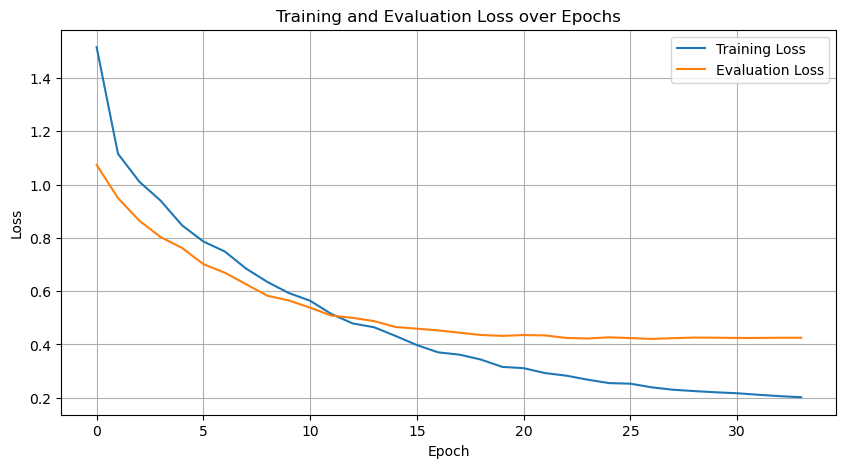

In [35]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = []
eval_loss = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Plotting the training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

In [45]:
results = trainer.evaluate()
print(results)

  0%|          | 0/170 [00:00<?, ?it/s]

{'eval_loss': 0.42492127418518066, 'eval_precision': 0.9080130196930308, 'eval_recall': 0.9071584541316987, 'eval_f1': 0.9074033559326743, 'eval_accuracy': 0.9071584541316987, 'eval_runtime': 2.6608, 'eval_samples_per_second': 1021.861, 'eval_steps_per_second': 63.89, 'epoch': 25.0}


ValueError: x and y must have same first dimension, but have shapes (34,) and (35,)

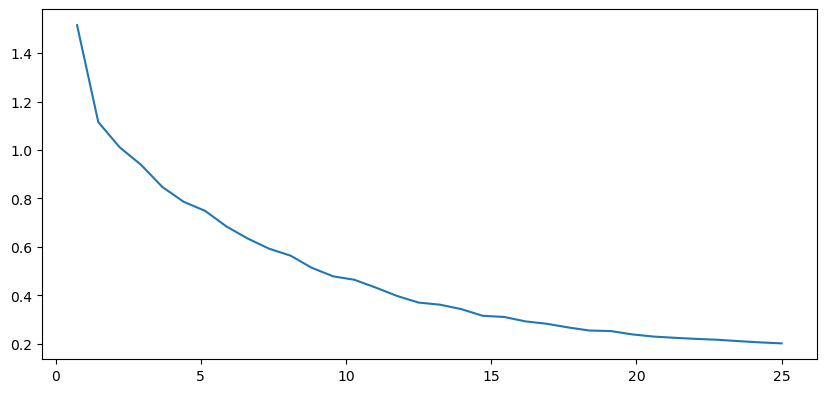

In [47]:
# Extract metrics
train_loss = []
eval_loss = []
eval_precision = []
eval_recall = []
eval_f1 = []
eval_accuracy = []
epochs = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_precision' in log:
        eval_precision.append(log['eval_precision'])
    if 'eval_recall' in log:
        eval_recall.append(log['eval_recall'])
    if 'eval_f1' in log:
        eval_f1.append(log['eval_f1'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plotting the metrics
plt.figure(figsize=(10, 10))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss over Epochs')
plt.legend()
plt.grid()

# Plot evaluation metrics
plt.subplot(2, 1, 2)
plt.plot(epochs[:len(eval_precision)], eval_precision, label='Precision')
plt.plot(epochs[:len(eval_recall)], eval_recall, label='Recall')
plt.plot(epochs[:len(eval_f1)], eval_f1, label='F1 Score')
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

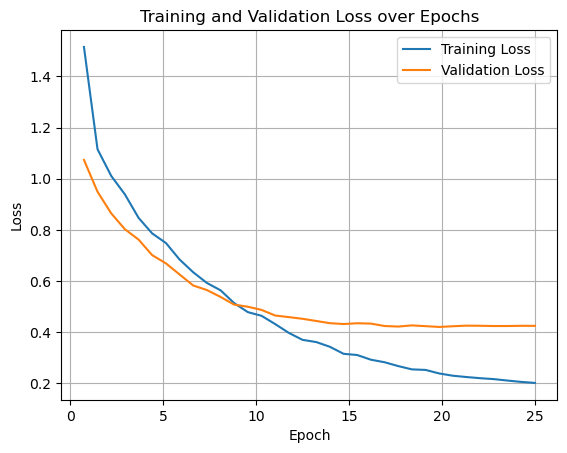

In [41]:
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig("imghasil/loss_ft_ner_25.png")
plt.grid()

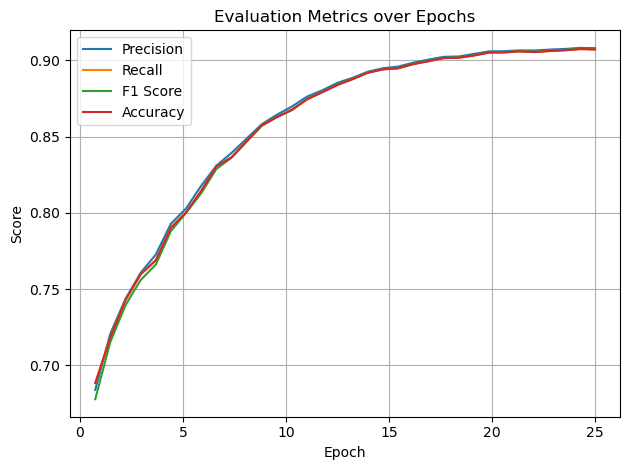

In [38]:

plt.plot(epochs[:len(eval_precision)], eval_precision, label='Precision')
plt.plot(epochs[:len(eval_recall)], eval_recall, label='Recall')
plt.plot(epochs[:len(eval_f1)], eval_f1, label='F1 Score')
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.grid()
plt.savefig("imghasil/eval_metrics_ft_ner25.png") 

plt.tight_layout()
plt.show()

In [39]:
# finetuned_ner = "queryner-ft-25"
# trainer.save_model(finetuned_ner)
# tokenizer.save_pretrained(finetuned_ner)

('queryner-ft-25\\tokenizer_config.json',
 'queryner-ft-25\\special_tokens_map.json',
 'queryner-ft-25\\vocab.txt',
 'queryner-ft-25\\added_tokens.json',
 'queryner-ft-25\\tokenizer.json')

In [42]:
from transformers import AutoModelForTokenClassification

non_finetuned_model = AutoModelForTokenClassification.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased", num_labels=len(label_to_id))
non_finetuned_trainer = Trainer(
    model=non_finetuned_model,
    args=training_args,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [43]:
non_finetuned_results = non_finetuned_trainer.evaluate()
print("Non-finetuned model results:", non_finetuned_results)

  0%|          | 0/170 [00:00<?, ?it/s]

Non-finetuned model results: {'eval_loss': 5.972297191619873, 'eval_precision': 0.3944311691708941, 'eval_recall': 0.30733208807976636, 'eval_f1': 0.3115005576476419, 'eval_accuracy': 0.30733208807976636, 'eval_runtime': 2.6726, 'eval_samples_per_second': 1017.343, 'eval_steps_per_second': 63.607}


In [46]:
#pretty print the results and non_finetuned_results
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(results)
pp.pprint(non_finetuned_results)

{'epoch': 25.0,
 'eval_accuracy': 0.9071584541316987,
 'eval_f1': 0.9074033559326743,
 'eval_loss': 0.42492127418518066,
 'eval_precision': 0.9080130196930308,
 'eval_recall': 0.9071584541316987,
 'eval_runtime': 2.6608,
 'eval_samples_per_second': 1021.861,
 'eval_steps_per_second': 63.89}
{'eval_accuracy': 0.30733208807976636,
 'eval_f1': 0.3115005576476419,
 'eval_loss': 5.972297191619873,
 'eval_precision': 0.3944311691708941,
 'eval_recall': 0.30733208807976636,
 'eval_runtime': 2.6726,
 'eval_samples_per_second': 1017.343,
 'eval_steps_per_second': 63.607}


# Perbandingan Query

In [96]:
# Define blacklist categories
black_list_categories = {
    "core_product_type": ["'", "s",  "g", "br", "-", "with"],
    "modifier": ["with", "for",  "-",],
    "department": ["for", "cur", "ho",  "-","with"],
    "occasion": ["for", "br", "s", "to",  "-","with"],
    "shape": ["with", "-", "tu", "with"],
    "material": ["for", "br", "s", "to", "-", "with"],
    "color": ["skate", "with", "colors",  "-", "color"],
    "creator": ["'", "s", "-", "with"],
    "UoM": ["for", "br", "s", "to",  "-", "with"],
    "price": ["on", "-", "with"],
    "product_name": ["y", "'", "s", "t", "g", "br", "-", "with"],
    "content": ["for", "br", "s", "to", "with"],
    "condition": ["for", "br", "s", "to", "with"],
    "quantity": ["for", "br", "s", "to", "with"],
    "origin": ["for", "br", "s", "to", "with"],
    "time": ["for", "br", "s", "to", "with"],
}

def get_entities_from_model_output(text, tokenizer, model, score_threshold=0.15):
    inputs = tokenizer(text, return_tensors="pt")
    tokens = inputs.tokens()

    with torch.no_grad():
        outputs = model(**inputs).logits

    predictions = torch.argmax(outputs, dim=2)
    scores = torch.softmax(outputs, dim=2).max(dim=2).values

    label_map = model.config.id2label
    entities = []

    for token, pred, score in zip(tokens, predictions[0], scores[0]):
        label = label_map[pred.item()]
        if label != "O" and score.item() > score_threshold:
            entities.append({
                "entity": label,
                "score": score.item(),
                "token": token
            })

    return entities

def post_process_entities(entities):
    processed_entities = []
    current_entity = None

    for token_info in entities:
        token, label, score = token_info["token"], token_info["entity"], token_info["score"]

        if token in ["[CLS]", "[SEP]"]:
            continue 

        if token.startswith("##"):
            if current_entity is not None:
                current_entity["score"] = min(current_entity["score"], score)
                current_entity["word"] += token[2:]

                # Update entity to non-modifier if necessary
                if label[2:] != "modifier" and current_entity["entity"] == "modifier":
                    current_entity["entity"] = label[2:]
        else:
            if current_entity is not None:
                processed_entities.append(current_entity)
            current_entity = {
                "entity": label[2:],  # Remove the B- or I- prefix
                "score": score,
                "word": token,
            }

    if current_entity:
        processed_entities.append(current_entity)

    return processed_entities
    
def filter_entities(entities, black_list_categories):
    filtered_entities = []
    for entity in entities:
        if entity['word'] not in black_list_categories.get(entity['entity'], []):
            filtered_entities.append(entity)
    return filtered_entities

def process_ner(texts, model, tokenizer, score_threshold=0.15):
    results = []
    for text in tqdm(texts, total=len(texts),  desc="Processing NER"):
        raw_entities = get_entities_from_model_output(text, tokenizer, model, score_threshold=score_threshold)
        processed_entities = post_process_entities(raw_entities)
        filtered_entities = filter_entities(processed_entities, black_list_categories)
        results.append(filtered_entities)
    return results

In [72]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

nft_tokenizer = AutoTokenizer.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased")
nft_model = AutoModelForTokenClassification.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased")
# nft_model = nft_model.to("cuda")

In [137]:
ft_tokenizer = AutoTokenizer.from_pretrained('queryner-ft-25')
ft_model = AutoModelForTokenClassification.from_pretrained('queryner-ft-25')
# ft_model = ft_model.to("cuda")

In [132]:
import pandas as pd

dfner = pd.read_csv('ner_this_please.csv')
dfner.head()

,Unnamed: 0,titles
0,0,Magenta Sword with Glowing Edge
1,1,Magenta Sword with Decorative Hilt
2,2,Magenta Sword for LARPing
3,3,Magenta Sword with Custom Engravings
4,4,Magenta Sword with Dual-Edge Blade


In [134]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from tqdm import tqdm
import pandas as pd

# Load the tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased")
# model = AutoModelForTokenClassification.from_pretrained("bltlab/queryner-augmented-data-bert-base-uncased")

# Define blacklist categories
black_list_categories = {
    "core_product_type": ["'", "s", "t", "g", "br", "-", "with"],
    "modifier": ["with", "for"],
    "department": ["for", "cur", "ho", "with"],
    "occasion": ["for", "br", "s", "to", "with"],
    "shape": ["with", "-", "tu", "with"],
    "material": ["for", "br", "s", "to", "with"],
    "color": ["skate", "with", "colors", "color"],
    "creator": ["'", "s", "-", "with"],
    "UoM": ["for", "br", "s", "to", "with"],
    "price": ["on", "with"],
    "product_name": ["y", "'", "s", "t", "g", "br", "-", "with"],
    "content": ["for", "br", "s", "to", "with"],
    "condition": ["for", "br", "s", "to", "with"],
    "quantity": ["for", "br", "s", "to", "with"],
    "origin": ["for", "br", "s", "to", "with"],
    "time": ["for", "br", "s", "to", "with"],
}

def get_entities_from_model_output(text, tokenizer, model, score_threshold=0.8):
    inputs = tokenizer(text, return_tensors="pt")
    tokens = inputs.tokens()

    with torch.no_grad():
        outputs = model(**inputs).logits

    predictions = torch.argmax(outputs, dim=2)
    scores = torch.softmax(outputs, dim=2).max(dim=2).values

    label_map = model.config.id2label
    entities = []

    for token, pred, score in zip(tokens, predictions[0], scores[0]):
        label = label_map[pred.item()]
        if label != "O" and score.item() > score_threshold:
            entities.append({
                "entity": label,
                "score": score.item(),
                "token": token
            })

    return entities

def post_process_entities(entities):
    processed_entities = []
    current_entity = None

    for token_info in entities:
        token, label, score = token_info["token"], token_info["entity"], token_info["score"]

        if token in ["[CLS]", "[SEP]"]:
            continue 

        if token.startswith("##"):
            if current_entity is not None:
                current_entity["score"] = min(current_entity["score"], score)
                current_entity["word"] += token[2:]

                # Update entity to non-modifier if necessary
                if label[2:] != "modifier" and current_entity["entity"] == "modifier":
                    current_entity["entity"] = label[2:]
        else:
            if current_entity is not None:
                processed_entities.append(current_entity)
            current_entity = {
                "entity": label[2:],  # Remove the B- or I- prefix
                "score": score,
                "word": token,
            }

    if current_entity:
        processed_entities.append(current_entity)

    return processed_entities
    
def filter_entities(entities, black_list_categories):
    filtered_entities = []
    for entity in entities:
        if entity['word'] not in black_list_categories.get(entity['entity'], []):
            filtered_entities.append(entity)
    return filtered_entities

def process_ner(texts, model, tokenizer, score_threshold=0.8):
    results = []
    for text in tqdm(texts, total=len(texts),  desc="Processing NER"):
        raw_entities = get_entities_from_model_output(text, tokenizer, model, score_threshold=score_threshold)
        processed_entities = post_process_entities(raw_entities)
        filtered_entities = filter_entities(processed_entities, black_list_categories)
        results.append(filtered_entities)
    return results

In [145]:
titles = dfner['titles'].tolist()
ner_results = process_ner(titles, model=ft_model, tokenizer=ft_tokenizer)

Processing NER: 100%|██████████| 1000/1000 [00:35<00:00, 28.25it/s]


In [146]:
def get_each_category_value(entity_results, category):
    categories = []
    for entities in entity_results:
        category_values = []
        for entity in entities:
            if entity["entity"] == category:
                category_values.append(entity["word"])
        if category_values:
            categories.append(category_values)
        else:
            categories.append([])
    return categories

output = get_each_category_value(ner_results, "color")
print(output)

[['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['mage'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['mage'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['mage'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['mage'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'], ['magenta'

In [152]:
for category in entity_category_counts.keys():
    output = get_each_category_value(ner_results, category)
    dfner[category] = output

In [157]:
dfner.to_csv('nerbaru.csv')

In [107]:
def create_comparison_df(baseline, fine_tuned, labels):
    data = {
        'Label': [],
        'Word': [],
        'Baseline Entity': [],
        'Baseline Score': [],
        'Fine-Tuned Entity': [],
        'Fine-Tuned Score': []
    }
    
    for i, (base_sent, tuned_sent) in enumerate(zip(baseline, fine_tuned)):
        for base, tuned in zip(base_sent, tuned_sent):
            data['Label'].append(labels[i])
            data['Word'].append(base['word'])
            data['Baseline Entity'].append(base['entity'])
            data['Baseline Score'].append(base['score'])
            data['Fine-Tuned Entity'].append(tuned['entity'])
            data['Fine-Tuned Score'].append(tuned['score'])
    
    return pd.DataFrame(data)

In [110]:
from pprint import pprint
# query = ["colorful t-shirt with slimfit spandex"]
query = [
            "evening gowns for formal events",
            "summer hats for women",
            "trendy handbags for women 2024"
        ]

# print("Baseline")
baseline_output = process_ner(query, model=nft_model, tokenizer=nft_tokenizer, score_threshold=0)

finetuned_output = process_ner(query, model=ft_model, tokenizer=ft_tokenizer, score_threshold=0)

# Convert outputs to DataFrames for comparison


labels = [f'Sentence {i+1}' for i in range(len(query))]
comparison_df = create_comparison_df(baseline_output, finetuned_output, labels)

# Print the DataFrame
comparison_df

Processing NER: 100%|██████████| 3/3 [00:00<00:00, 28.22it/s]


,Label,Word,Baseline Entity,Baseline Score,Fine-Tuned Entity,Fine-Tuned Score
0,Sentence 1,evening,modifier,0.995956,occasion,0.988026
1,Sentence 1,gowns,core_product_type,0.953988,core_product_type,0.999952
2,Sentence 1,formal,modifier,0.999682,occasion,0.998183
3,Sentence 1,events,modifier,0.997467,occasion,0.915298
4,Sentence 2,summer,occasion,0.999923,occasion,0.737769
5,Sentence 2,hats,core_product_type,0.999923,core_product_type,0.999981
6,Sentence 2,women,department,0.999931,department,0.999965
7,Sentence 3,trendy,modifier,0.993939,modifier,0.999957
8,Sentence 3,handbags,core_product_type,0.999885,core_product_type,0.999965
9,Sentence 3,women,department,0.999932,department,0.999933


In [130]:
query = [
            "Small Magenta Speaker",
           # "summer hats for women",
           # "trendy handbags for women 2024"
        ]
baseline_output = process_ner(query, model=nft_model, tokenizer=nft_tokenizer, score_threshold=0)
finetuned_output = process_ner(query, model=ft_model, tokenizer=ft_tokenizer, score_threshold=0)
comparison_df = create_comparison_df(baseline_output, finetuned_output, labels)
comparison_df


Processing NER: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


,Label,Word,Baseline Entity,Baseline Score,Fine-Tuned Entity,Fine-Tuned Score
0,Sentence 1,small,UoM,0.999941,UoM,0.999928
1,Sentence 1,magenta,color,0.999842,color,0.998760
2,Sentence 1,speaker,core_product_type,0.999974,core_product_type,0.999922


# Train Ulang

In [ ]:
import pandas as pd
twitter = pd.read_csv('twt_queries.csv', usecols=['product', 'created_at']) 
twitter.dropna(subset=['product'], inplace=True)
twitter.head(10)
print(len(twitter))

4857


In [ ]:
import pandas as pd
gt = pd.read_csv('gt_queries.csv', usecols=['product', 'ts']) 
gt.dropna(subset=['product'], inplace=True)
gt.head(10)

,product,ts
0,NFL Team Jersey,8/1/2024
1,NFL Game Tickets,8/1/2024
2,NFL Logo Hat,8/1/2024
3,Fantasy Football Draft Kit,8/1/2024
4,NFL Collectible Trading Cards,8/1/2024
5,Olympic Golf Balls,8/1/2024
6,Olympic Golf T-Shirt,8/1/2024
7,Olympic Golf Hat,8/1/2024
8,Golf Clubs Set,8/1/2024
9,Golf Gloves,8/1/2024


In [ ]:
finetuned_ner = "queryner-augmented-data-bert-base-uncased-finetuned"

model = AutoModelForTokenClassification.from_pretrained(finetuned_ner)
tokenizer = AutoTokenizer.from_pretrained(finetuned_ner)

In [49]:
# Define blacklist categories
black_list_categories = {
    "core_product_type": ["'", "s",  "g", "br", "-", "with"],
    "modifier": ["with", "for"],
    "department": ["for", "cur", "ho", "with"],
    "occasion": ["for", "br", "s", "to", "with"],
    "shape": ["with", "-", "tu", "with"],
    "material": ["for", "br", "s", "to", "with"],
    "color": ["skate", "with", "colors", "color"],
    "creator": ["'", "s", "-", "with"],
    "UoM": ["for", "br", "s", "to", "with"],
    "price": ["on", "with"],
    "product_name": ["y", "'", "s", "t", "g", "br", "-", "with"],
    "content": ["for", "br", "s", "to", "with"],
    "condition": ["for", "br", "s", "to", "with"],
    "quantity": ["for", "br", "s", "to", "with"],
    "origin": ["for", "br", "s", "to", "with"],
    "time": ["for", "br", "s", "to", "with"],
}

def get_entities_from_model_output(text, tokenizer, model, score_threshold=0.15):
    inputs = tokenizer(text, return_tensors="pt")
    tokens = inputs.tokens()

    with torch.no_grad():
        outputs = model(**inputs).logits

    predictions = torch.argmax(outputs, dim=2)
    scores = torch.softmax(outputs, dim=2).max(dim=2).values

    label_map = model.config.id2label
    entities = []

    for token, pred, score in zip(tokens, predictions[0], scores[0]):
        label = label_map[pred.item()]
        if label != "O" and score.item() > score_threshold:
            entities.append({
                "entity": label,
                "score": score.item(),
                "token": token
            })

    return entities

def post_process_entities(entities):
    processed_entities = []
    current_entity = None

    for token_info in entities:
        token, label, score = token_info["token"], token_info["entity"], token_info["score"]

        if token in ["[CLS]", "[SEP]"]:
            continue 

        if token.startswith("##"):
            if current_entity is not None:
                current_entity["score"] = min(current_entity["score"], score)
                current_entity["word"] += token[2:]

                # Update entity to non-modifier if necessary
                if label[2:] != "modifier" and current_entity["entity"] == "modifier":
                    current_entity["entity"] = label[2:]
        else:
            if current_entity is not None:
                processed_entities.append(current_entity)
            current_entity = {
                "entity": label[2:],  # Remove the B- or I- prefix
                "score": score,
                "word": token,
            }

    if current_entity:
        processed_entities.append(current_entity)

    return processed_entities
    
def filter_entities(entities, black_list_categories):
    filtered_entities = []
    for entity in entities:
        if entity['word'] not in black_list_categories.get(entity['entity'], []):
            filtered_entities.append(entity)
    return filtered_entities

def process_ner(texts, model, tokenizer, score_threshold=0.15):
    results = []
    for text in tqdm(texts, total=len(texts),  desc="Processing NER"):
        raw_entities = get_entities_from_model_output(text, tokenizer, model, score_threshold=score_threshold)
        processed_entities = post_process_entities(raw_entities)
        filtered_entities = filter_entities(processed_entities, black_list_categories)
        results.append(filtered_entities)
    return results

In [50]:
query = "colorful t-shirt with slimfit spandex"
process_ner(query, model=model, tokenizer=tokenizer)

Processing NER:   0%|          | 0/37 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
titles = twitter['product'].tolist()
ner_results = process_ner(titles, model=model, tokenizer=tokenizer)

Processing NER: 100%|██████████| 4857/4857 [03:31<00:00, 22.95it/s]


In [ ]:
def get_each_category_value(entity_results, category):
    categories = []
    for entities in entity_results:
        category_values = []
        for entity in entities:
            if entity["entity"] == category:
                category_values.append(entity["word"])
        if category_values:
            categories.append(category_values)
        else:
            categories.append([])
    return categories

output = get_each_category_value(ner_results, "core_product_type")
print(output)

[['dresses'], ['dresses'], ['dresses'], ['dresses'], ['dresses'], [], ['accessories'], ['jewelry'], ['decor', 'items'], ['decorations'], ['packages'], ['song', 'playlists'], ['books'], ['t', 'shirt'], ['merchandise'], ['apparel'], ['shoulder', 'top'], ['skirt'], ['high', 'heels'], ['makeup', 'kit'], ['beauty', 'filter'], ['t', 'shirts'], ['prints'], ['magazines'], ['accessories'], [], ['outfit'], ['skin', 'customization'], ['accessories'], ['photo', 'editing', 'software'], ['merchandise'], ['accessories'], ['products'], ['dress'], ['kurta'], [], [], ['accessories'], ['gift', 'boxes'], ['gift', 'packaging'], ['gift', 'boxes'], [], [], ['kurta', 'sets'], ['cards'], ['home', 'decor'], ['magazine'], ['merchandise'], ['records'], ['art', 'prints'], [], ['luggage'], ['carry', 'on', 'bags'], ['accessories'], ['clothing'], ['outfit'], ['guide'], ['book'], ['art', 'tickets'], ['accessories'], ['clothing'], ['music', 'video', 'dvd'], ['t', 'shirts'], ['wear'], ['guitar', 'picks'], ['art', 'print

In [ ]:
entity_categories = set()
for entities in ner_results:
    for entity in entities:
        entity_categories.add(entity["entity"])

entity_category_counts = {category: 0 for category in entity_categories}
for entities in ner_results:
    for entity in entities:
        entity_category_counts[entity["entity"]] += 1

entity_category_counts = {k: v for k, v in sorted(entity_category_counts.items(), key=lambda item: item[1], reverse=True)}
entity_category_counts

{'core_product_type': 5768,
 'modifier': 3057,
 'creator': 1674,
 'department': 1143,
 'occasion': 902,
 'product_name': 866,
 'color': 402,
 'material': 393,
 'content': 173,
 'time': 132,
 'origin': 129,
 'quantity': 98,
 'UoM': 98,
 'condition': 92,
 'shape': 67,
 'product_number': 30,
 'price': 14}

In [ ]:
for category in entity_category_counts.keys():
    output = get_each_category_value(ner_results, category)
    twitter[category] = output

In [ ]:
twitter.T.head(20)

,0,1,2,3,4,5,6,7,8,9,...,4868,4869,4870,4871,4872,4873,4874,4875,4876,4877
product,maxi dresses,bodycon dresses,wrap dresses,plus size dresses,boho dresses,traditional Indian lehenga,wedding accessories,bridal jewelry set,wedding decor items,dance floor decorations,...,Hijab Outfit Set,designer clothing,fashion accessories,photo shoot outfits,lingerie,luxury robes,buy one get one free winter blouse,winter fashion tops,seasonal women's shirts,discount winter clothing
created_at,Fri Jun 23 11:11:13 +0000 2023,Fri Jun 23 11:11:13 +0000 2023,Fri Jun 23 11:11:13 +0000 2023,Fri Jun 23 11:11:13 +0000 2023,Fri Jun 23 11:11:13 +0000 2023,Fri Jun 23 12:53:21 +0000 2023,Fri Jun 23 12:53:21 +0000 2023,Fri Jun 23 12:53:21 +0000 2023,Fri Jun 23 12:53:21 +0000 2023,Fri Jun 23 12:53:21 +0000 2023,...,Mon Feb 13 12:12:20 +0000 2023,Sat Feb 11 03:06:40 +0000 2023,Sat Feb 11 03:06:40 +0000 2023,Sat Feb 11 03:06:40 +0000 2023,Sat Feb 11 03:06:40 +0000 2023,Sat Feb 11 03:06:40 +0000 2023,Sun Feb 12 14:42:21 +0000 2023,Sun Feb 12 14:42:21 +0000 2023,Sun Feb 12 14:42:21 +0000 2023,Sun Feb 12 14:42:21 +0000 2023
core_product_type,[dresses],[dresses],[dresses],[dresses],[dresses],[],[accessories],[jewelry],"[decor, items]",[decorations],...,"[hijab, outfit]",[clothing],[accessories],[outfits],[lingerie],[robes],[blouse],[tops],[shirts],[clothing]
modifier,[],[],[wrap],[],[boho],[traditional],[],[],[],[],...,[],[designer],[fashion],[],[],[luxury],[],[fashion],[],[]
creator,[],[bodycon],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
department,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],"[women, ', s]",[]
occasion,[],[],[],[],[],[],[wedding],[bridal],[wedding],"[dance, floor]",...,[],[],[],"[photo, shoot]",[],[],[],[],[seasonal],[winter]
color,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
material,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
product_name,[],[],[],[],[],[lehenga],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [ ]:
gt.columns

Index(['product', 'ts', 'core_product_type', 'modifier', 'creator',
       'department', 'occasion', 'color', 'material', 'product_name',
       'content', 'origin', 'UoM', 'time', 'condition', 'quantity', 'shape',
       'product_number', 'price'],
      dtype='object')

In [ ]:
gt.to_csv('gt_queries_ner.csv', index=False)

In [ ]:
twitter.to_csv('twt_queries_ner.csv', index=False)